# High Temperature

In [1]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_absolute_error,
)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import layers
from keras.regularizers import l2
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [2]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\04-High_Temp - Practice.csv"
df = pd.read_csv(filePath)

In [3]:
# Function to check if the number of SMILES corresponds to the number of entries in the ratio
def find_entries_with_difference(data):
    differing_entries = []


# Initialize an empty list to store differing entries
differing_entries = []

# Iterate through the DataFrame
for i, row in df.iterrows():
    smiles = row["Smiles"].split(",")
    ratios = row["Molar ratio"].split(":")

    # Check if the number of SMILES is different from the number of ratios
    if len(smiles) != len(ratios):
        differing_entries.append(
            (i + 1, row["SMPname"], row["Reference"], row["Smiles"], row["Molar Ratio"])
        )

# Print only the entries with differences
if differing_entries:
    print("Entries with differences in numbers of SMILES and ratios:")
    for line, SMPname, reference, smiles, ratio in differing_entries:
        print(f"Line {line}: {SMPname}-{reference}-{smiles} - {ratio}")
else:
    print("All entries have matching numbers of SMILES and ratios.")

All entries have matching numbers of SMILES and ratios.


In [4]:
# Initialize a list to store the line numbers with sums of ratios not equal to 1
lines_with_non_one_sums = []

# Iterate through the DataFrame
for i, row in df.iterrows():
    ratios = row["Molar ratio"].split(":")

    # Calculate the sum of ratios
    ratio_sum = sum(float(ratio) for ratio in ratios)

    # Check if the sum is not equal to 1
    if (
        abs(ratio_sum - 1.0) > 1e-6
    ):  # Use a small tolerance for floating-point comparison
        lines_with_non_one_sums.append(i + 1)  # Append line number to the list

# Check the result and print line numbers with sums of ratios not equal to 1
if not lines_with_non_one_sums:
    print("The sum of ratios is equal to 1 in all rows.")
else:
    print("Lines with sums of 'Molar ratio' not equal to 1:")
    for line in lines_with_non_one_sums:
        print(f"Line {line}: {df.loc[line-1, 'Molar ratio']}")

The sum of ratios is equal to 1 in all rows.


In [5]:
#
smiles = df["Smiles"]
smiles = [list(smile.strip("{} ").split(",")) for smile in smiles]

molar_ratio = df["Molar ratio"]
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(":")]
    m_r.append(ratio_list)

In [6]:
"""'
functions for fingerprinting and multiplication of
fingerprinted monomers by their respective molar ratios
"""


# function for storing fingerprints monomers as a representation of the polymers
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 6, 1800)
    return fp


def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp


def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)


fingerprinted_polymer_data = []

for i, (polymer, polymer_m_r) in enumerate(zip(smiles, m_r)):
    try:
        fingerprinted_polymer = fingerprint_polymer(polymer)
        multiplied_polymer = [
            multiply_fingerprint(fp, m_r_value)
            for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)
        ]
        fingerprinted_polymer_data.append(multiplied_polymer)
    except Exception as e:
        print(f"Error occurred at data point {i+1}")
        print(f"SMILES causing the error: {polymer}")
        traceback.print_exc()
# flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

# find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [
    np.pad(arr, (0, max_length - len(arr)), mode="constant") for arr in flattened_arr
]

new_array = np.stack(padded_arrays)

In [7]:
X = new_array
y = df["High Temp"]  # specify y

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2, shuffle=True
)

# # Initialize the scaler
# scaler = StandardScaler()
# scaler.fit(X_train)

# # Fit the scaler on the training data and transform it
# X_train = scaler.transform(X_train)

# # Apply the same transformation to the test data
# X_test= scaler.transform(X_test)

# x_plot = np.linspace(0, 12)
# y_plot = x_plot

### ANN Model

Epoch 1/500
9/9 [==============================] - 3s 52ms/step - loss: 113.8231 - mape: 99.4859 - val_loss: 111.7580 - val_mape: 99.7110
Epoch 2/500
9/9 [==============================] - 0s 15ms/step - loss: 111.1340 - mape: 96.6302 - val_loss: 110.7370 - val_mape: 98.7135
Epoch 3/500
9/9 [==============================] - 0s 16ms/step - loss: 104.4940 - mape: 89.5277 - val_loss: 107.7665 - val_mape: 95.7696
Epoch 4/500
9/9 [==============================] - 0s 16ms/step - loss: 87.8118 - mape: 71.8901 - val_loss: 98.9907 - val_mape: 87.0400
Epoch 5/500
9/9 [==============================] - 0s 15ms/step - loss: 51.1514 - mape: 39.4551 - val_loss: 77.1618 - val_mape: 65.9026
Epoch 6/500
9/9 [==============================] - 0s 16ms/step - loss: 32.7792 - mape: 33.3203 - val_loss: 71.4360 - val_mape: 61.6987
Epoch 7/500
9/9 [==============================] - 0s 16ms/step - loss: 28.3606 - mape: 27.9499 - val_loss: 67.8554 - val_mape: 59.4893
Epoch 8/500
9/9 [=========================

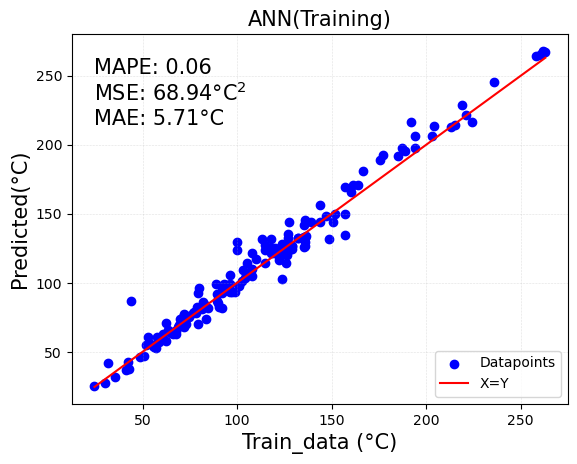

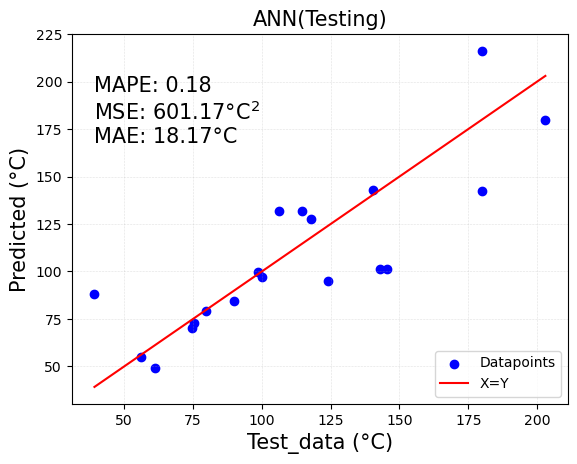

In [9]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", #kernel_regularizer=l2(0.1),
                              input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=20,
    validation_data=(X_test, y_test),
    #callbacks=[mycallback],
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (°C)", fontsize=15)
plt.ylabel("Predicted(°C)", fontsize=15)
plt.text(
    min(y_train),
    max(y_train),
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}°C$^2$\nMAE: {MAE_train:.2f}°C",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", label="X=Y")
plt.xlabel("Test_data (°C)", fontsize=15)
plt.ylabel("Predicted (°C)", fontsize=15)
plt.text(
    min(y_test),
    max(y_test),
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}°C$^2$\nMAE: {MAE_test:.2f}°C",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()

In [10]:
# Create a DataFrame to display y_test and y_test_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred.flatten()})
print(results_df)

     y_test  y_test_pred
6    180.00   142.413025
156   74.48    70.265121
108   98.59    99.656830
137  140.26   142.928635
12    89.86    84.324150
35    75.50    73.067940
164   56.01    55.154045
3     39.20    87.977341
139   79.79    78.957191
45   203.00   179.919128
48   180.00   216.157394
154  142.85   101.233002
78   118.00   127.868706
29   114.63   131.885529
161   61.04    49.100151
25   106.23   131.685883
159  145.48   101.233002
13   100.00    97.320564
99   124.00    94.956360


Epoch 1/500
57/57 [==============================] - 10s 48ms/step - loss: 82.9251 - mape: 72.8471 - val_loss: 30.0103 - val_mape: 27.6766
Epoch 2/500
57/57 [==============================] - 1s 25ms/step - loss: 22.1957 - mape: 22.8418 - val_loss: 13.9009 - val_mape: 14.8023
Epoch 3/500
57/57 [==============================] - 2s 30ms/step - loss: 12.9487 - mape: 14.5310 - val_loss: 12.0098 - val_mape: 12.2625
Epoch 4/500
57/57 [==============================] - 2s 27ms/step - loss: 10.8868 - mape: 12.0840 - val_loss: 10.8062 - val_mape: 11.0518
Epoch 5/500
57/57 [==============================] - 2s 28ms/step - loss: 9.2966 - mape: 9.7507 - val_loss: 10.2991 - val_mape: 9.8620
Epoch 6/500
57/57 [==============================] - 2s 30ms/step - loss: 8.0888 - mape: 8.1923 - val_loss: 9.6598 - val_mape: 9.4536
Epoch 7/500
57/57 [==============================] - 2s 27ms/step - loss: 6.9258 - mape: 7.0538 - val_loss: 9.1684 - val_mape: 8.6660
Epoch 8/500
57/57 [=========================

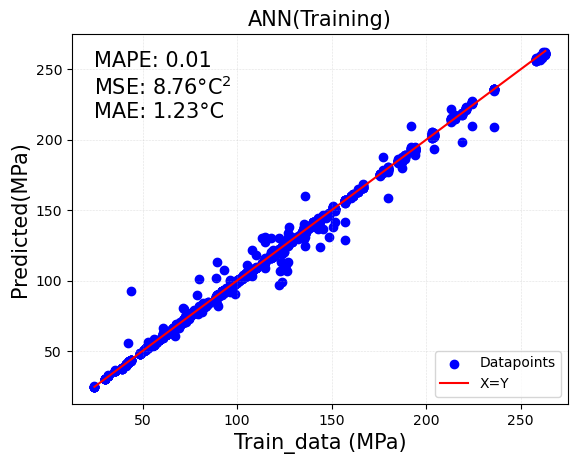

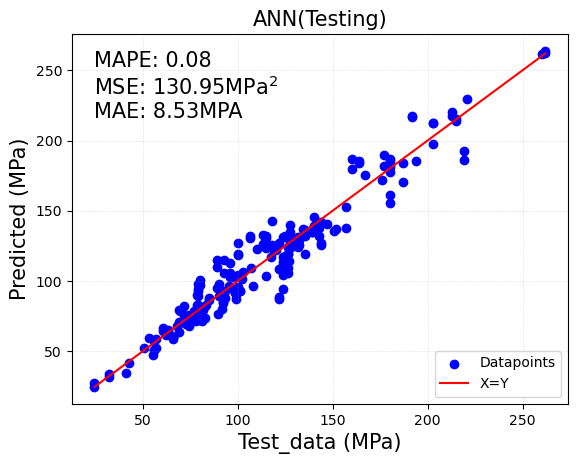

     y_test  y_test_pred
0     79.04    82.776680
1    187.00   184.028290
2     75.50    71.030441
3     84.79    86.376160
4    160.00   179.931229
..      ...          ...
197  117.68   117.246750
198  213.00   217.128159
199   90.00    89.029068
200  110.00   122.686859
201  117.97   124.025101

[202 rows x 2 columns]


In [11]:
# Define the data augmentation function
def augment_data(X, y, num_augmentations):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        for _ in range(num_augmentations):
            noise = np.random.normal(0, 0.01, X[i].shape)  # Adjust the noise level as needed
            augmented_sample = X[i] + noise
            augmented_X.append(augmented_sample)
            augmented_y.append(y[i])

    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    return augmented_X, augmented_y

num_augmentations = 10  # You can adjust this number as needed

# Perform data augmentation
augmented_X, augmented_y = augment_data(X, y, num_augmentations)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_X, augmented_y, test_size=0.1, random_state=42, shuffle=True)

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu",
                              input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ])

# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)


# Create a DataFrame to display y_test and y_test_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred.flatten()})

# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (MPa)", fontsize=15)
plt.ylabel("Predicted(MPa)", fontsize=15)
plt.text(
    min(y_train),
    max(y_train),
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}°C$^2$\nMAE: {MAE_train:.2f}°C",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", label="X=Y")
plt.xlabel("Test_data (MPa)", fontsize=15)
plt.ylabel("Predicted (MPa)", fontsize=15)
plt.text(
    min(y_test),
    max(y_test_pred),
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}°C$^2$\nMAE: {MAE_test:.2f}°C",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()
print(results_df)

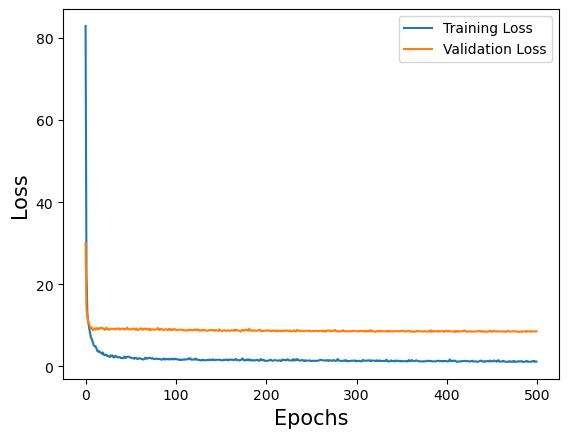

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.show()